In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import scipy.stats.distributions as dist
import urllib
from PIL import Image

In [2]:
os.chdir('../')

In [3]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'

In [4]:
full_data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [5]:
question_order = ['t01_smooth_or_features'
                  ,'t02_edgeon'
                  ,'t04_spiral'
                  ,'t11_arms_number']

colors = ['r','b','g','y']
colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [6]:
# Load all of the data

def load_dataset(question,answer):
    '''Load the bin data and debiased values'''
    
    data_dir = 'output_files/{}/{}/'.format(question,answer)
    
    bins = Table.read(data_dir+'bins.fits')
    debiased = Table.read(data_dir+'debiased.fits')
    fit_results = Table.read(data_dir+'fit_results.fits')
    vbins_table = Table.read(data_dir+'vbin_parameters.fits')
    all_bins = Table.read(data_dir+'all_bins.fits')
    fit_setup = pickle.load(open(data_dir+'fit_setup.p', "rb" ))
    
    return bins,all_bins,debiased,fit_results,vbins_table,fit_setup


def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction',sharex=True,sharey=True,stack=False,width=20):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    
    height = (y_dimension/x_dimension)*width
    
    if stack == True:
        fig,axes = plt.subplots(n_morph,1,sharex=sharex,sharey=sharey,figsize=(10,3*n_morph))
    else:
        fig,axes = plt.subplots(y_dimension,x_dimension,sharex=sharex,sharey=sharey,figsize=(width,
                                                                                             height))
        if n_morph >= 3:
            for ax in axes[-1,:]:
                ax.set_xlabel(xlabel)
            for ax in axes[:,0]:
                ax.set_ylabel(ylabel) 
        else:
            axes[0].set_xlabel(xlabel)
            axes[0].set_ylabel(ylabel)
            axes[1].set_xlabel(xlabel)
        axes=axes.ravel()
        for m in remove_axes:
            fig.delaxes(axes[m])
    
    plt.subplots_adjust(hspace=0,wspace=0)

    return fig,axes


def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh_normalised'
    else:
        suffix = '_debiased_rh'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        select = np.ones(len(full_data)) == 1
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced,select

In [7]:
bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset('t11_arms_number',
                                                                        'a36_more_than_4')

In [8]:
def plot_v_bins(question,answer,n_plot=100):

    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)

    vbins = all_bins['vbin']
    Mr = full_data['PETROMAG_MR']
    R50 = full_data['PETROR50_R_KPC']

    relative_r = [((T-T.min())/(T.max()-T.min())) for T in [np.log10(vbins_table['R50']),vbins_table['Mr']]]
    relative_r = relative_r[1]**2# + relative_r[0]**2
    r_sort = np.argsort(relative_r) # Trying to get neighbouring bins in different colours.
    
    N_gal = np.sum(full_data[question + '_' + answer + '_weighted_fraction'] > 0)
    N_bin = len(np.unique(vbins))
    print(N_gal,N_bin)

    for v in np.unique(vbins)[r_sort]:
        inbin = vbins == v
        
        data_plot = full_data[inbin]
        i_values = np.arange(0,len(data_plot))
        np.random.shuffle(i_values)
        if n_plot != None:
            i_values = i_values[:n_plot]
        
        plt.plot(data_plot['PETROR50_R_KPC'][i_values],
                 data_plot['PETROMAG_MR'][i_values],'.',markersize=8)
    
    for v in range(len(vbins_table)):
        x_text_pos = 10**(vbins_table['R50'][v])
        y_text_pos = vbins_table['Mr'][v]
        #plt.text(x_text_pos,y_text_pos,'{}'.format(v),
                 #color='w',horizontalalignment='center',
                 #verticalalignment='center')

    plt.ylabel(r"$M_r$")
    plt.xlabel(r"$R_{50}$ (kpc)")
    plt.xscale('log')

    _ = plt.axis((0.5, 60, -18, -25))
    
    return None

In [9]:
def normalise(data):
    
    mean_val = np.mean(data)
    std_val = np.std(data)
    normed = (data-mean_val)/std_val
    
    return normed

In [10]:
def plot_k_vs_c_values(question,answer):
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    
    k_vals = fit_results['k']
    c_vals = fit_results['c']
    z = fit_results['redshift']
    
    plt.scatter(k_vals,c_vals,c=z,cmap=plt.cm.coolwarm,s=30,lw=0)
    
    plt.xlabel('k')
    plt.ylabel('c')
    
    return None

In [11]:
from scipy.stats import binned_statistic

def plot_histograms(questions,question_dictionary,log=False):
    
    B = np.linspace(0,1,11)
    
    N_list = []
    for Q in questions:
        N_ans = len(question_dictionary[Q]['answers'])
        N_list.append(N_ans)
    
    x_dimension = np.max(N_list)
    y_dimension = len(questions)
    
    if len(questions) > 1:
        fig,axarr = plt.subplots(y_dimension,x_dimension,figsize=(15,15*(y_dimension/x_dimension)),
                                 sharex=True,sharey=True)
        for ax in axarr[:,0]:
            ax.set_ylabel('normalised fraction')
        for ax in axarr[-1,:]:
            ax.set_xlabel('$p$')
            
    else:
        fig,axarr = make_axes(N_ans,sharex=True,sharey=True,
                              xlabel='$p$',ylabel='normalised fraction')
        axarr = np.array([axarr])
    
    plt.subplots_adjust(hspace=0,wspace=0)
    
    for y,Q in enumerate(questions):
        
        answers = question_dictionary[Q]['answers']
        q_label = question_dictionary[Q]['questionlabel']
        a_labels = question_dictionary[Q]['answerlabels']
        
        data,select = reduce_sample(full_data,question_dictionary,Q)
        
        if len(answers) > 3:
            C = colors_long
        else:
            C = colors
        
        vl_data = data[data['in_volume_limit']]
        low_z = (vl_data['REDSHIFT_1'] > 0.03) & (vl_data['REDSHIFT_1'] <= 0.035)
        high_z = (vl_data['REDSHIFT_1'] > 0.08) & (vl_data['REDSHIFT_1'] <= 0.085)
        
        for x,A in enumerate(answers):
        
            answer_debiased = vl_data[Q + '_' + A + '_debiased_rh']
            answer_w13 = vl_data[Q + '_' + A + '_debiased']
            answer_raw = vl_data[Q + '_' + A + '_weighted_fraction']
            
            _ = axarr[y,x].hist(answer_debiased[low_z],normed=True,bins=B
                                ,color='k',linewidth=0,alpha=0.5
                                ,histtype='stepfilled')
            _ = axarr[y,x].hist(answer_w13[high_z],normed=True,bins=B
                                ,color=C[x],linewidth=3,histtype='step'
                                ,linestyle='dotted')
            _ = axarr[y,x].hist(answer_debiased[high_z],normed=True,bins=B
                                ,color=C[x],linewidth=2,histtype='step'
                                ,linestyle='solid')
            
            axarr[y,x].text(0.5,0.95,'Q:{}, A:{}'.format(q_label,a_labels[x])
                            ,transform=axarr[y,x].transAxes
                            ,horizontalalignment='center',verticalalignment='top'
                            ,fontsize=15)
            
            if log == True:
                axarr[y,x].set_yscale('log')
    
    return None


def plot_thresholds(questions,question_dictionary,p_th=0.5):
    
    fig,axarr = make_axes(len(questions),xlabel='redshift'
                          ,ylabel='$f(p>{{{}}})$'.format(p_th))
    plt.subplots_adjust(hspace=0,wspace=0)
    
    lines = ['solid','dotted','dashed']
    
    for y,Q in enumerate(questions):
        
        answers = question_dictionary[Q]['answers']
        q_label = question_dictionary[Q]['questionlabel']
        a_labels = question_dictionary[Q]['answerlabels']
        
        data,select = reduce_sample(full_data,question_dictionary,Q)
        
        if len(answers) > 3:
            C = colors_long
        else:
            C = colors
        
        vl_data = data[data['in_volume_limit']]
        
        for x,A in enumerate(answers):
        
            answer_debiased = vl_data[Q + '_' + A + '_debiased_rh_normalised']
            answer_w13 = vl_data[Q + '_' + A + '_debiased']
            answer_raw = vl_data[Q + '_' + A + '_weighted_fraction']
            z_values = vl_data['REDSHIFT_1']
            
            z_vals,bins = bin_by_column(z_values,20)
            
            for x2,column in enumerate([answer_raw,answer_w13,answer_debiased]):
                
                a_label = [a_labels[x],None,None]
                
                fracs = get_fractions(column,bins,p_th)
                axarr[y].plot(z_vals,fracs,linewidth=2
                              ,linestyle=lines[x2],label=a_label[x2],color=C[x])
            
            axarr[y].text(0.5,0.95,'Q:{}'.format(q_label)
                            ,transform=axarr[y].transAxes
                            ,horizontalalignment='center',verticalalignment='top'
                            ,fontsize=15)
            
            axarr[y].legend(prop={'size':14})
            
    return None


def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_fractions(column,bins,th=0.5):
    
    fracs = np.zeros(len(np.unique(bins)))
    
    for m,b in enumerate(np.unique(bins)):
        
        bin_data = column[bins == b]
        fracs[m] = np.sum(bin_data > th)/len(bin_data)
        
    return fracs

In [12]:
def hist_tree(question,questions,p_th=0.5,N_th=5,width=10):
    
    datasets = ['raw','w13','debiased']
    linestyles = ['solid','dotted','dashed']
    linewidths = [2,3,2.5]
    colors = ['red','blue','green']
    
    pre_questions = questions[question]['pre_questions']
    
    N_y = len(pre_questions)
    N_x = 2
    height = (N_y/N_x)*(width)
    fig,axarr = plt.subplots(N_y,N_x,figsize=(width,height),sharex=True)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    
    hist_bins = np.linspace(0,1,11)
    
    for n,dataset in enumerate(datasets):
        if dataset == 'raw':
            suffix = '_weighted_fraction'
        elif dataset == 'w13':
            suffix = '_debiased'
        else:
            suffix = '_debiased_rh'
        
        for y,Q in enumerate(pre_questions):
            data,select = reduce_sample(full_data,questions,Q,dataset=dataset)
            
            in_volume_limit = data['in_volume_limit'] == True
            vl = data[in_volume_limit]
            answers = questions[Q]['answers']
            
            nz = 10
            zv,zb = bin_by_column(vl['REDSHIFT_1'],nbins = nz)  
            fracs = np.zeros(nz)
            
            hz = (vl['REDSHIFT_1'] > 0.08) & (vl['REDSHIFT_1'] <= 0.085)
            lz = (vl['REDSHIFT_1'] > 0.03) & (vl['REDSHIFT_1'] <= 0.035)
            
            for x,A in enumerate(answers):
                
                answer_column = vl[Q + '_' + A + suffix]
                
                if n == 0: # only plot x1
                    axarr[y,x].hist(vl[Q + '_' + A + '_weighted_fraction'][lz]
                                      ,bins=hist_bins,histtype='stepfilled'
                                      ,color='k',alpha=0.5,normed=True)
                
                axarr[y,x].hist(answer_column[hz],bins=hist_bins,histtype='step',
                                  color=colors[x],linestyle=linestyles[n],linewidth=linewidths[n],normed=True)
                
                #for i,z in enumerate(np.unique(zb)):
                    #answer_th = answer_column[zb == z] > 0.5
                    #fracs[i] = np.sum(answer_th)/len(answer_th)
                    #axarr[y,0].plot(zv,fracs,color=colors[x]
                                    #,linestyle=linestyles[n]
                                    #,linewidth=linewidths[n])
    
        for ax in axarr[-1]:
            ax.set_xlabel('$p$')
        for ax in axarr[:,0]:
            ax.set_ylabel('normalised fraction')  
    
    return None

def plot_tree(question,questions,p_th=0.5,N_th=5,width=10):
    
    datasets = ['raw','w13','debiased']
    linestyles = ['solid','dotted','dashed']
    linewidths = [2,3,2.5]
    colors = ['red','blue','green']
    
    pre_questions = questions[question]['pre_questions']
    
    N_y = len(pre_questions)
    N_x = 1
    height = (N_x/N_y)*(width)
    fig,axarr = plt.subplots(N_x,N_y,figsize=(width,height),sharex=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    '''
    
    for n,dataset in enumerate(datasets):
        if dataset == 'raw':
            suffix = '_weighted_fraction'
        elif dataset == 'w13':
            suffix = '_debiased'
        else:
            suffix = '_debiased_rh'
        
        for y,Q in enumerate(pre_questions):
            data,select = reduce_sample(full_data,questions,Q,dataset=dataset)
            
            in_volume_limit = data['in_volume_limit'] == True
            vl = data[in_volume_limit]
            answers = questions[Q]['answers'][:2]
            
            nz = 10
            zv,zb = bin_by_column(vl['REDSHIFT_1'],nbins = nz)  
            fracs = np.zeros(nz)
            
            for x,A in enumerate(answers):
                answer_column = vl[Q + '_' + A + suffix]
                for i,z in enumerate(np.unique(zb)):
                    answer_th = answer_column[zb == z] > 0.5
                    fracs[i] = np.sum(answer_th)/len(answer_th)
                    
                    axarr[y].plot(zv,fracs,color=colors[x]
                                    ,linestyle=linestyles[n]
                                    ,linewidth=linewidths[n])
                    
    '''
    for ax in axarr[:]:
        ax.set_xlabel('redshift')
        
    axarr[0].set_ylabel(r'$f(p>0.5)$')
    plt.axis([0,1,0.03,0.09])
    
    return None

In [13]:
def plot_curve_fits(question,question_dictionary,max_bins_to_plot=4,vbin=0,title=True,width=20):
    
    data,select = reduce_sample(full_data,questions,question)

    # make colour array of blue -> red:
    colour_array = np.zeros((max_bins_to_plot,3))
    colour_array[:,1] = 0
    colour_array[:,0] = np.linspace(0,1,max_bins_to_plot)
    colour_array[:,2] = 1 - colour_array[:,0]
    
    answers = question_dictionary[question]['answers']
    labels = question_dictionary[question]['answerlabels']
    
    n_morph = len(answers)
    fig,axarr = make_axes(n_morph,sharex=True,sharey=True,xlabel=r'$\log(p)$',width=width)
    xg = np.linspace(-2,0,100)

    for n,answer in enumerate(answers):
    
        bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
        
        f_r_sigma = fit_results[fit_results['in_2sigma'] == True]
        
        kmin,kmax,cmin,cmax = [np.min(f_r_sigma['k']),np.max(f_r_sigma['k'])
                               ,np.min(f_r_sigma['c']),np.max(f_r_sigma['c'])]
        # Set limits here:
        fit_results['kf'][fit_results['kf'] > kmax] = kmax
        fit_results['kf'][fit_results['kf'] < kmin] = kmin
        fit_results['cf'][fit_results['cf'] > cmax] = cmax
        fit_results['cf'][fit_results['cf'] < cmin] = cmin
    
        zbins = bins['zbin']
        vbins = bins['vbin']
        func = fit_setup['func']
    
        vsel = vbins == vbin

        column = data[question + '_' + answer + '_weighted_fraction']
        zbins_v = zbins[vsel]
    
        z_bin_values = np.unique(zbins_v)
        z_bin_cf = np.linspace(0,1,len(z_bin_values))
        plot_cf = np.linspace(0,1,max_bins_to_plot)
    
        indices = np.searchsorted(z_bin_cf,plot_cf)
        indices = indices.clip(0,len(z_bin_cf)-1)
        bins_to_plot = z_bin_values[indices]
    
        axarr[n].text(0.925,0.075,'$m$={}'.format(labels[n]),
                      transform=axarr[n].transAxes,
                      ha='right',va='bottom')

        for m,z in enumerate(bins_to_plot):
    
            zsel = zbins == z
            zv_column = column[(vsel) & (zsel)]
    
            cf = np.linspace(0,1,len(zv_column))
            fv = np.sort(zv_column)
            fv_nonzero = fv != 0
            log10fv = np.log10(fv[fv_nonzero])
            cf_plot = cf[fv_nonzero]
    
            fit = fit_results[(fit_results['vbin'] == vbin) 
                              & (fit_results['zbin'] == z)]
        
            clr = colour_array[m]

            k = fit['k']
            c = fit['c']
            kf = fit['kf']
            cf = fit['cf']
            
            axarr[n].plot(xg,func(xg,k,c),color=clr,linestyle='dashed',linewidth=2,alpha=0.75)
            axarr[n].plot(xg,func(xg,kf,cf),color=clr,linestyle='dotted',linewidth=3)  
            axarr[n].plot(log10fv,cf_plot,color=clr,linewidth=4,alpha=0.5)
        
    plt.axis([-2,0,0,1])
    if title == True:
        plt.suptitle('Voronoi bin = {}'.format(vbin))
    
    return None

In [14]:
def plot_arm_number_fractions(full_sample,question_dictionary,num_bins=20,th=None):
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    
    answers = question_dictionary['t11_arms_number']['answers']

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    print('{} galaxies with p>0.5 and N>=5'.format(len(spirals)))
    
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers[:-1]]
    raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    if th != None:
        select = np.max(arm_array,axis=1) > th
    else:
        select = np.ones(len(spirals)) == 1
    
    arm_assignments = np.argmax(arm_array,axis=1)
    raw_assignments = np.argmax(raw_array,axis=1)
    
    arm_assignments = arm_assignments[select]
    raw_assignmnets = raw_assignments[select]
    spirals = spirals[select]
    redshifts = spirals['REDSHIFT_1']
    
    z,bins = bin_by_column(redshifts,num_bins)
        
    fig,axarr = plt.subplots(5,1,sharex=True,sharey=False,figsize=(10,13.5))
    plt.subplots_adjust(hspace=0,wspace=0)
    
    labels = question_dictionary['t11_arms_number']['answerlabels']
    
    for m in range(5):
        fracs = get_arm_fraction(arm_assignments,bins,m)
        fracs_raw = get_arm_fraction(raw_assignments,bins,m)
        axarr[m].plot(z,fracs['f'],linewidth=2,linestyle='solid',color=colors_long[m])
        axarr[m].plot(z,fracs_raw['f'],linewidth=2,linestyle='dashed',color=colors_long[m])
        axarr[m].fill_between(z,fracs['low_f'],fracs['high_f'],color=colors_long[m],alpha=0.5)
        axarr[m].fill_between(z,fracs_raw['low_f'],fracs_raw['high_f'],color=colors_long[m],alpha=0.25)
        
        guideline = np.mean(fracs['f'])
        axarr[m].hlines(guideline,0.03,0.09,color=colors_long[m],linestyle=':',linewidth=3)
        axarr[m].set_ylabel('$f_{{{}}}$'.format(labels[m]))
        #axarr[m].text(0.05,0.85,'m={}'.format(labels[m]),transform=axarr[m].transAxes)
    
    axarr[m].set_xlim(0.03,0.09)
    axarr[-1].set_xlabel('redshift')
    
    return None


def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper

In [15]:
def raw_debiased_scatter(full_data,question,questions=questions,volume_limit=True,method=None,Np=None):
    
    N = len(questions[question]['answers'])
    fig,axarr = make_axes(n_morph=N,xlabel='$f_v$(raw)'
                          ,ylabel='$f_v$(debiased)')
    labels = questions[question]['answerlabels']
    
    if volume_limit == True:
        vl_select = full_data['in_volume_limit'] == 1
    else:
        vl_select = np.ones(len(full_data))
        vl_select = vl_select == 1
        
    data,select = reduce_sample(full_data,questions,question)
    vl = full_data[(vl_select) & (select)]
    indices = np.arange(0,len(vl))
    random.shuffle(indices)
    
    if Np != None:
        i_sel = indices[0:Np]
    else:
        i_sel = indices.copy()
    vl = vl[i_sel]
    z = vl['REDSHIFT_1']
    
    for m,answer in enumerate(questions[question]['answers']):
        
        if method != None:
            bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
            debiased_plot = debiased[method + '_method'][(vl_select) & (select)][i_sel]
        else:
            debiased_plot = vl[question + '_' + answer + '_debiased_rh']
        
        raw_plot = vl[question + '_' + answer + '_weighted_fraction']
        
        plt.sca(axarr[m])
        plt.scatter(raw_plot,debiased_plot,c=z,cmap=plt.cm.coolwarm,lw=0,s=20)
        axarr[m].text(0.1,0.9,'m={}'.format(labels[m]),ha='left',va='top',transform=axarr[m].transAxes)
        axarr[m].set_xlim(0,1)
        axarr[m].set_ylim(0,1)
    
    return None

In [16]:
def plot_fits(a,ax,question,x='k',y='kf',questions=questions):
    
    label = questions[question]['answerlabels'][a]
    answer = questions[question]['answers'][a]
    
    plt.sca(ax)
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    
    f_r_sigma = fit_results[fit_results['in_2sigma'] == True]
        
    kmin,kmax,cmin,cmax = [np.min(f_r_sigma['k']),np.max(f_r_sigma['k'])
                           ,np.min(f_r_sigma['c']),np.max(f_r_sigma['c'])]
    # Set limits here:
    fit_results['kf'][fit_results['kf'] > kmax] = kmax
    fit_results['kf'][fit_results['kf'] < kmin] = kmin
    fit_results['cf'][fit_results['cf'] > cmax] = cmax
    fit_results['cf'][fit_results['cf'] < cmin] = cmin

    z = fit_results['redshift']

    plt.scatter(fit_results[x],fit_results[y],c=z,cmap=plt.cm.coolwarm,lw=0,s=50)

    # get axes:
    x_lower,x_upper = ax.get_xlim()
    y_lower,y_upper= ax.get_ylim()

    limits = [np.min([x_lower,y_lower]),np.min([x_upper,y_upper])]
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.plot(limits,limits,'k-')
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    cbar = plt.colorbar()
    
    ax.text(0.05,0.95,label,ha='left',va='top',transform=ax.transAxes)
    
    return None


def plot_kc_fit(a):
    fig,axarr = plt.subplots(1,2,figsize=(15,5))
    axarr = axarr.ravel()
    
    plot_fits(a,ax=axarr[0],question='t11_arms_number')
    plot_fits(a,ax=axarr[1],question='t11_arms_number',x='c',y='cf')
    return None

In [17]:
def display_image(url_name,crop_in=100):
    # Get the url name:
    urllib.request.urlretrieve(url_name,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    im=im.crop((crop_in,crop_in,l-crop_in,l-crop_in))
    plt.imshow(im)
    os.remove("image.jpg")
    plt.xticks([])
    plt.yticks([])
    return None


def image_page(question,question_dictionary,mass_cut=[10.5,11],p_cut=[0.5,0.6]
               ,N_bin=5,title=True,print_ID=False,saved=True):
    
    figlabels = 'abcdefghijklmnopqrstuvwxyz'
    j = 0
    
    answers = question_dictionary[question]['answers'][:-1]
    answer_labels = question_dictionary[question]['answerlabels']
    N_ans = len(answers)

    fig,axarr = plt.subplots(N_ans,N_bin,figsize=(18.5,18.5))
    plt.subplots_adjust(hspace=0.025,wspace=0.025)
    
    # get the spiral galaxy sample:
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    spirals = data[(remove_ct) & (in_volume_limit)]
    
    # Make cuts of mass and probability threshold?
    
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    
    if saved:
        raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers]
        raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    p_values = np.max(arm_array,axis=1)
    masses = spirals['LOGMSTAR_BALDRY06']
    
    if saved:
        save_cut = np.argmax(arm_array,axis=1) != np.argmax(raw_array,axis=1)
        print('saved:{}/{}'.format(np.sum(save_cut),len(save_cut)))
        p_m_cut = ((p_values <= p_cut[1]) & (p_values > p_cut[0]) &
                   (masses <= mass_cut[1]) & (masses > mass_cut[0]) &
                   (save_cut))
    else:
        p_m_cut = ((p_values <= p_cut[1]) & (p_values > p_cut[0]) &
                   (masses <= mass_cut[1]) & (masses > mass_cut[0]))
    
    arm_assignments = np.argmax(arm_array,axis=1)
    arm_assignments[p_m_cut == False] = -999 # mask out the galaxies that don't make the cuts
    
    # Now divide in to redshift bins:
    redshift = spirals['REDSHIFT_1']
    zv,z_bins = bin_by_column(redshift,N_bin,fixedcount=False)
    
    url_names = spirals['jpeg_url']
    ids = spirals['dr7objid_1']
    
    i_array = np.arange(0,len(url_names))
    
    for y,m in enumerate(range(5)):
        for x,z in enumerate(np.unique(z_bins)):
        
            i_reduced = i_array[(p_m_cut) & (z_bins == z) &
                                (arm_assignments == m)]
        
            if len(i_reduced) > 0:
                i = random.choice(i_reduced)
                url = url_names[i]
                p_raw = spirals[question + '_' + answers[m] + '_weighted_fraction'][i]
            
                axarr[y,x].text(0.5,0.95,'$p_{raw}=' + '{0:.2f}$'.format(p_raw)
                                ,transform=axarr[y,x].transAxes,ha='center',va='top',color='white')
                
                axarr[y,x].text(0.05,0.95,'({})'.format(figlabels[j])
                                ,transform=axarr[y,x].transAxes,ha='left',va='top',color='white')
                j = j + 1
                
                plt.sca(axarr[y,x])
                display_image(url)
                
                if print_ID:
                    print('m={},z={},ID={}'.format(m,z,ids[i]))
            else:
                fig.delaxes(axarr[y,x])
            
    bin_edges = np.linspace(0.03,0.085,6) # do this more 'robustly' later
            
    y_labels = ['$m$={}'.format(l) for l in answer_labels]
    x_labels = ['${0:.3f}'.format(bin_edges[n]) +  
                '< z \leq {0:.3f}$'.format(bin_edges[n+1]) for n in range(len(bin_edges)-1)]
    
    for n,ax in enumerate(axarr[:,0]):
        ax.set_ylabel(y_labels[n])
    for n,ax in enumerate(axarr[-1,:]):
        ax.set_xlabel(x_labels[n])
    
    if title == True:
        plt.suptitle('$ {0:.1f} < M_*'.format(mass_cut[0]) +  '\leq {0:.1f}'.format(mass_cut[1]) 
                     + ',\, {0:.1f}'.format(p_cut[0]) +  '< p_{debiased}' +  '\leq {0:.1f}$'.format(p_cut[1]))
    
    return None

In [18]:
# Add a line of code to look at the 5+ armed fractions with redshift:

def plot_5_arm_fractions(full_sample,question_dictionary,num_bins=20):
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    
    answer = 'a36_more_than_4'
    question = 't11_arms_number'

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    print('{} galaxies with p>0.5 and N>=5'.format(len(spirals)))
    
    answers = question_dictionary[question]['answers']
    
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers[:-1]]
    raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    arm_assignments = np.argmax(arm_array,axis=1)
    raw_assignments = np.argmax(raw_array,axis=1)
    redshifts = spirals['REDSHIFT_1']
    
    z,bins = bin_by_column(redshifts,num_bins)
    
    labels = question_dictionary['t11_arms_number']['answerlabels']

    fracs = get_arm_fraction(arm_assignments,bins,4)
    fracs_raw = get_arm_fraction(raw_assignments,bins,4)
    
    plt.plot(z,fracs['f'],linewidth=2,linestyle='dashed',color='b')
    plt.plot(z,fracs_raw['f'],linewidth=2,linestyle='solid',color='b')
    plt.fill_between(z,fracs['low_f'],fracs['high_f'],color='b',alpha=0.5)
    plt.fill_between(z,fracs_raw['low_f'],fracs_raw['high_f'],color='b',alpha=0.25)
    
    # plot a 'maximum' line:
    for th in [0,0.05,0.1]:
        num_max = data[in_volume_limit][question + '_' + answer + '_weighted_fraction'] > th
        fracs_max = get_arm_fraction(num_max,bins,1)
        plt.plot(z,fracs_max,color='k',linewidth=1.5)
        plt.text(z[-1]+0.001,fracs_max['f'][-1],'$p>{}$'.format(th)
                 ,color='k',ha='left',va='center')
        
    guideline = fracs_raw['f'][0]
    plt.hlines(guideline,0.03,0.1,color='b',linestyle=':',linewidth=3)
    plt.ylabel('fraction')
    plt.xlim(0.03,0.1)
    plt.xlabel('redshift')
    
    return None

In [19]:
def plot_high_z_5_arm_galaxies(question_dictionary,num_bins=10,p_values=np.linspace(0,0.1,6)):
    
    fig,axarr = plt.subplots(1,len(p_values)-1,figsize=(20,4))
    plt.subplots_adjust(hspace=0.01,wspace=0.01)
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    
    answer = 'a36_more_than_4'
    question = 't11_arms_number'

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    
    answers = question_dictionary[question]['answers']
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers[:-1]]
    raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    arm_assignments = np.argmax(arm_array,axis=1)
    raw_assignments = np.argmax(raw_array,axis=1)
    redshifts = spirals['REDSHIFT_1']
    
    z,bins = bin_by_column(redshifts,num_bins)
    
    max_bin = np.max(np.unique(bins))
    high_z_value = z[-1]
    
    high_z_spirals = spirals[bins == max_bin]
    high_z_arms = arm_assignments[bins == max_bin]
    i_full = np.arange(0,len(high_z_spirals))
    
    for n,p in enumerate(p_values[:-1]):
        
        fv_list = high_z_spirals[question + '_' + answer + '_weighted_fraction']
        
        i_list = i_full[(fv_list > p_values[n]) & 
                        (fv_list <= p_values[n+1]) & 
                        (high_z_arms != 4)]
        i = random.choice(i_list)
        
        original_class = high_z_arms[i]
        
        url = high_z_spirals[i]['jpeg_url']
        fv = high_z_spirals[i][question + '_' + answer + '_weighted_fraction']
        zv = high_z_spirals[i]['REDSHIFT_1']
        plt.sca(axarr[n])
        display_image(url)
        axarr[n].text(0.5,0.95,'$p=' + '{0:.2f}$'.format(fv),color='w',
                      transform=axarr[n].transAxes,ha='center',va='top')
        axarr[n].text(0.5,0.05,'$z=' + '{0:.3f}$'.format(zv),color='w',
                      transform=axarr[n].transAxes,ha='center',va='bottom')
        axarr[n].text(0.5,0.75,'m={}'.format(original_class+1),color='w',
                      transform=axarr[n].transAxes,ha='center',va='bottom')
        
    return None

# Results

Firstly plot the number of galaxies satisfying the condition p>0.5 for each of the questions in turn. The solid lines indicate the raw vote fractions, the dashed lines show the results from our debiasing, and the dotted lines show the results from the Willett+ 2013 debiasing- we do a much better job, particularly on the spiral or not question:

In [ ]:
#plot_thresholds(question_order,questions,p_th=0.5)

Now look at the histograms for each of the questions in turn (we will look at the arm number question in more detail later). The grey histogram shows the distribution at 0.03 < z < 0.035 as a reference. The solid line shows the results of our debiasing, the dashed line shows the results form Willett+ 2013 (both at 0.08 < z < 0.085):

An example plot of the voronoi bins and k values as a function of c (for the 5+ arms question):

In [ ]:
Q = 't11_arms_number'
A = 'a36_more_than_4'

qlabel = questions[Q]['questionlabel']
alabel = questions[Q]['answerlabels'][4]

'''
fig,axarr = plt.subplots(1,2,figsize=(15,7.5))
plt.sca(axarr[0])
plot_v_bins(Q,A)
plt.sca(axarr[1])
plot_k_vs_c_values(Q,A)
'''
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.text(0.5,0.98,'Q = arms number (T10), A = more than 4 (A4)',va='top',ha='center'
        ,transform=ax.transAxes)
ax.text(0.65,0.35,'$N_{gal}$ = 14903',transform=ax.transAxes,va='bottom',ha='left')
ax.text(0.65,0.3,'$N_{bins}$ = 25',transform=ax.transAxes,va='bottom',ha='left')

plot_v_bins(Q,A,n_plot=250)

plt.savefig('Plotting_codes/figures/voronoi_bins.pdf')

Example of fitted curves to the spiral arm number question (blue -> red with redshift):

In [ ]:
plot_curve_fits('t11_arms_number',questions,vbin=10,title=False,width=20)

plt.savefig('Plotting_codes/figures/vbin_fit.pdf')

Histograms of high and low redshift comparisons. The grey underlying histogram shows the vote fraction histogram for 0.03 < z < 0.035 as a comparison. Solid lines show the results of our debiasing, the dotted lines show the equivalent results from Willett+ 2013 (both with 0.08 < z < 0.085):

In [ ]:
import matplotlib.transforms as transforms

def find_nearest(array,value):
    i = (np.abs(array-value)).argmin()
    return i

def plot_given_galaxy(question,answer,values=[0.18]):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    colors = ['b','r']
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    sample,select = reduce_sample(full_data,questions,question)
    #fv_nonzero = sample[question + '_' + answer + '_debiased_rh'] != 0
    #sample = sample[fv_nonzero]
    #bins = bins[fv_nonzero]
    
    i = find_nearest(sample['REDSHIFT_1'],0.08)
    vbin_val = bins['vbin'][i]
    zbin_val = bins['zbin'][i]
    ref_val = 1
    
    low_z = (bins['vbin'] == vbin_val) & (bins['zbin'] == ref_val)
    high_z = (bins['vbin'] == vbin_val) & (bins['zbin'] == zbin_val)
    
    bin_edges = np.linspace(-1.8,0,30)
        
    hists = [None,None]
    
    for c,dataset in enumerate([sample[low_z],sample[high_z]]):
        
        answer_column = np.log10(np.sort(dataset[question + '_' + answer + '_weighted_fraction']))
        
        lb = ('${0:.3f}<z'.format(np.min(dataset['REDSHIFT_1'])) + 
             '\leq{0:.3f}$'.format(np.max(dataset['REDSHIFT_1'])))
        
        if c == 0:
            hists[c] = plt.hist(answer_column,cumulative=True,normed=True,bins=bin_edges,
                            histtype='step',color=colors[c],linewidth=1.5,label=lb)
            plt.vlines(0,0,1,color='w',linewidth=2)
        else:
            dx, dy = -2/72., 0 
            offset = transforms.ScaledTranslation(dx, dy,fig.dpi_scale_trans)
            tfm = ax.transData + offset
            hists[c] = plt.hist(answer_column,cumulative=True,normed=True,bins=bin_edges,
                            histtype='step',color=colors[c],linewidth=1.5,label=lb,transform=tfm)
            plt.vlines(0,0,1,color='w',linewidth=2,transform=tfm)

    for c,value in enumerate(values):
        i = find_nearest(hists[0][1],math.log10(value))
        plt.vlines(hists[0][1][i],0,hists[0][0][i],color='k',linewidth=3,linestyle='dotted')
        
        i2 = find_nearest(hists[1][0],hists[0][0][i])
        plt.vlines(hists[1][1][i2],0,hists[1][0][i2],color='k',linewidth=3,linestyle='dotted')
    
    plt.ylim(0,1)
    plt.xlabel('$\log(p)$')
    plt.ylabel('cumulative fraction')
    plt.legend(loc=2)
    
    return 10**(hists[1][1][i2]),10**(hists[0][1][i])

In [ ]:
def plot_means(vl_data,question_dict,question
               ,n_bins=10,threshold=0.5):
    
    question_label = question_dict[question]['questionlabel']
    answer_labels = question_dict[question]['answerlabels']
    answers = question_dict[question]['answers']
    
    if len(answers) > 3:
        C = colors_long
    else:
        C = colors
    
    data,select = reduce_sample(vl_data,question_dict,question)
    z_values = data['REDSHIFT_1']
    z_vals,bins = bin_by_column(z_values,10)
    
    handles = []
    
    for a,answer in enumerate(answers):
        
        deb_column = data[question + '_' + answer + '_debiased_rh_normalised']
        deb_fracs = get_fractions(deb_column,bins,threshold)
        raw_column = data[question + '_' + answer + '_weighted_fraction']
        raw_fracs = get_fractions(raw_column,bins,threshold)
        w13_column = data[question + '_' + answer + '_debiased']
        w13_fracs = get_fractions(w13_column,bins,threshold)
        
        plt.plot(z_vals,deb_fracs,color=C[a],linewidth=1.5,
                 linestyle='dashed')
        _ = plt.plot(z_vals,raw_fracs,color=C[a],linewidth=2,
                     label=answer_labels[a],linestyle='solid')
        plt.plot(z_vals,w13_fracs,color=C[a],linewidth=2,
                 linestyle='dotted')
        
        plt.text(0.1,0.98,question_label,family='serif'
                 ,horizontalalignment='left',verticalalignment='top'
                 ,transform = plt.gca().transAxes,size=15)
        plt.text(0.1,0.92,'{} galaxies'.format(len(data)),family='serif'
                 ,horizontalalignment='left',verticalalignment='top'
                 ,transform = plt.gca().transAxes,size=15)
      
        lgd = plt.legend(bbox_to_anchor=(0,0,1,1),bbox_transform=plt.gca().transAxes,prop={'size':13})
        
    return None

In [ ]:
_ = plot_given_galaxy('t01_smooth_or_features','a02_features_or_disk',values=[10**(-0.2)])

plt.savefig('Plotting_codes/figures/histogram_matching.pdf')

In [ ]:
plot_histograms(['t11_arms_number'],questions,log=True)

Relative sample sizes as a function of z- it seems we do a very good job on all but the 5+ armed question. The reason why I believe that this is the case is that it is the fraction that drops off most quickly with redshift- the result can be seen when looking at how well the k and c values are fit as a function of z, and this means that we don't seem to get a 'clean' fit of k vs k-fit:

58679/228201 galaxies with p>0.5 and N>=5.
17953 galaxies with p>0.5 and N>=5


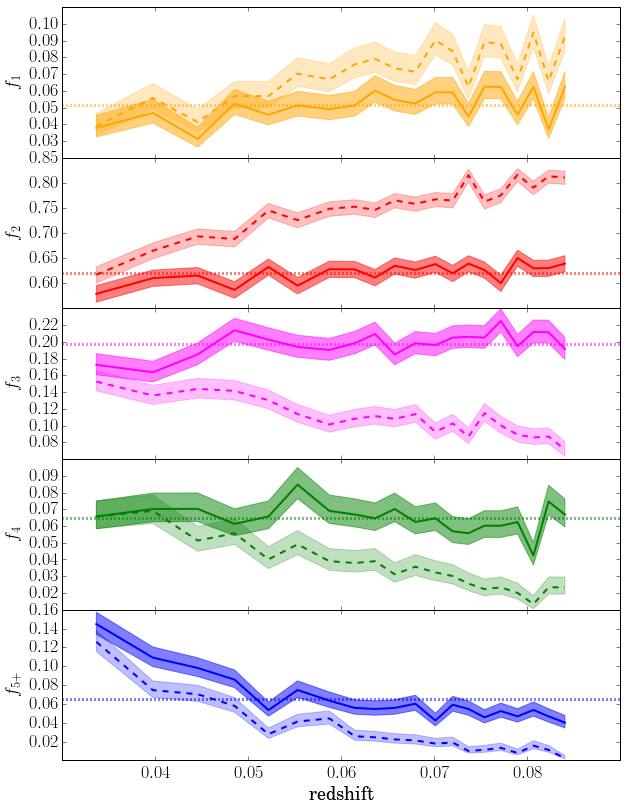

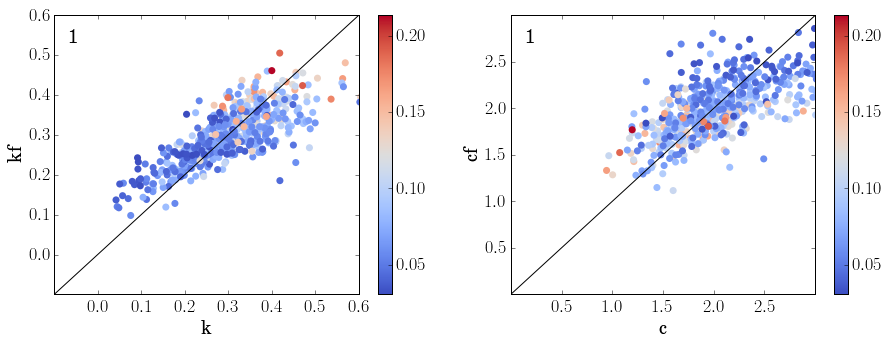

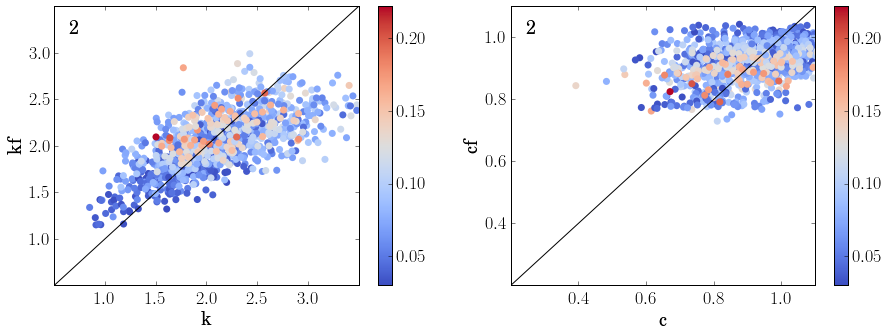

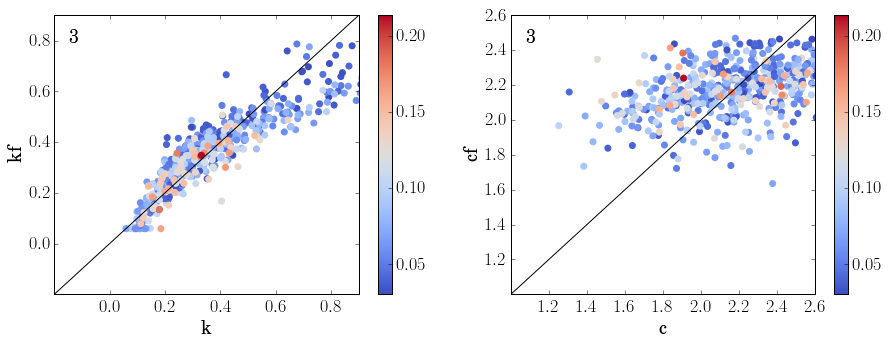

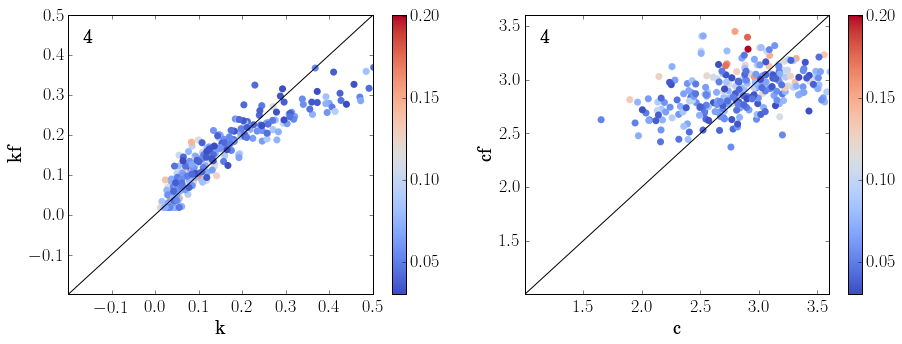

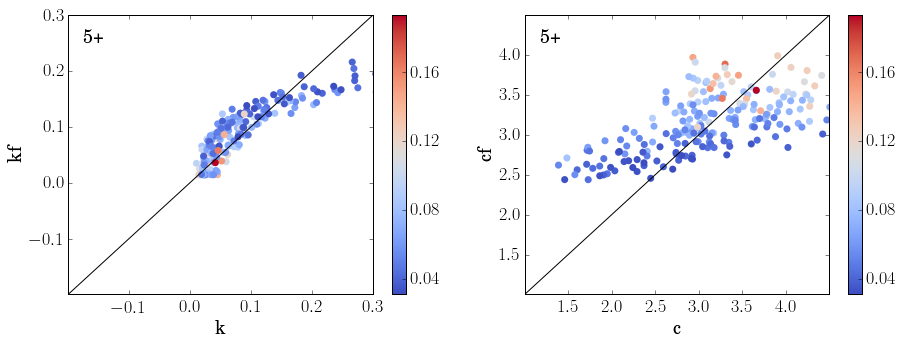

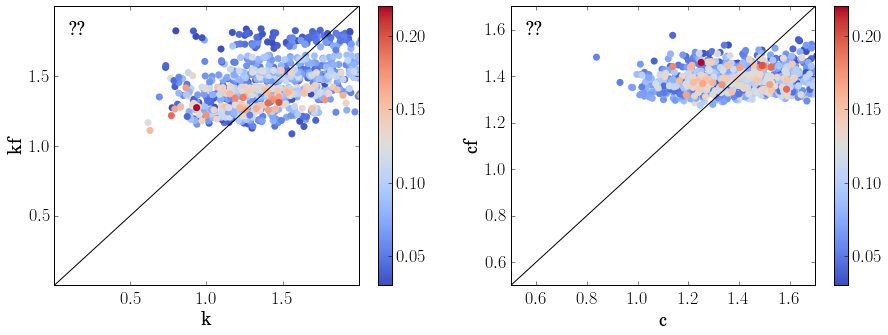

In [20]:
#plot_arm_number_fractions(full_sample,questions,20,th=0)
plt.savefig('Plotting_codes/figures/sample_fractions.pdf')
for a in range(len(questions['t11_arms_number']['answers'])):
    plot_kc_fit(a)

In [58]:
def plot_kc_fit_difference(a,zc='redshift'):
    fig,axarr = plt.subplots(1,2,figsize=(15,5))
    axarr = axarr.ravel()
    
    plot_fit_difference(a,ax=axarr[0],question='t11_arms_number',zc=zc)
    plot_fit_difference(a,ax=axarr[1],question='t11_arms_number',x='c',y='cf',zc=zc)
    return None


def plot_fit_difference(a,ax,question,x='k',y='kf',questions=questions,zc='redshift'):
    
    label = questions[question]['answerlabels'][a]
    answer = questions[question]['answers'][a]
    
    plt.sca(ax)
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    
    f_r_sigma = fit_results[fit_results['in_2sigma'] == True]
        
    kmin,kmax,cmin,cmax = [np.min(f_r_sigma['k']),np.max(f_r_sigma['k'])
                           ,np.min(f_r_sigma['c']),np.max(f_r_sigma['c'])]
    # Set limits here:
    fit_results['kf'][fit_results['kf'] > kmax] = kmax
    fit_results['kf'][fit_results['kf'] < kmin] = kmin
    fit_results['cf'][fit_results['cf'] > cmax] = cmax
    fit_results['cf'][fit_results['cf'] < cmin] = cmin

    z = fit_results[zc]

    plt.scatter(z,fit_results[x]-fit_results[y],lw=0,s=30,alpha=0.5)

    # get axes:
    x_lower,x_upper = ax.get_xlim()
    y_lower,y_upper= ax.get_ylim()

    limits = [np.min([x_lower,y_lower]),np.min([x_upper,y_upper])]
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('{}  - {}'.format(x,y))
    
    ax.text(0.05,0.95,label,ha='left',va='top',transform=ax.transAxes)
    
    return None

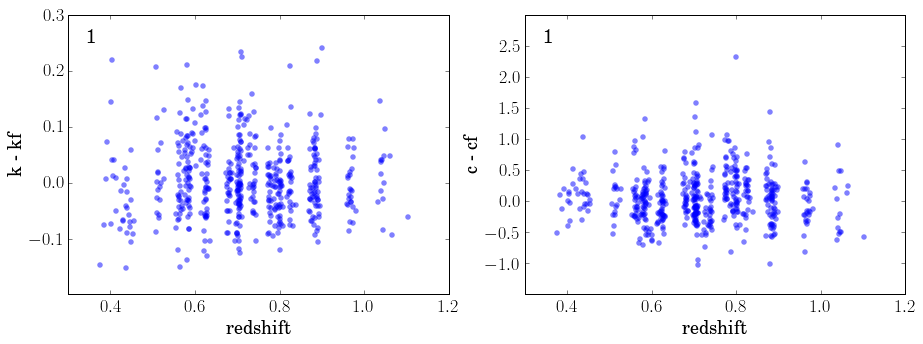

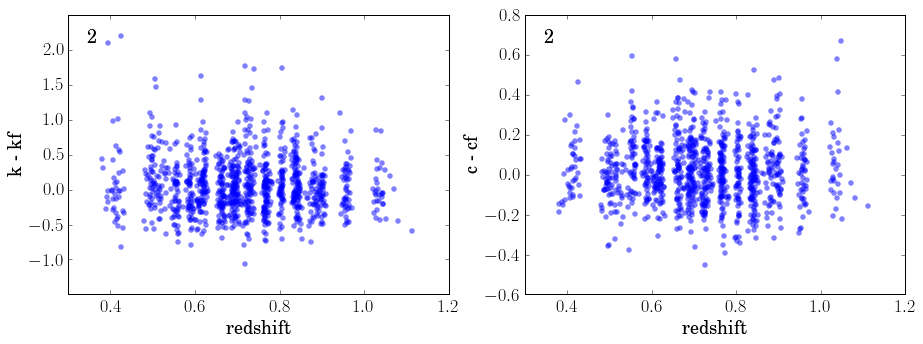

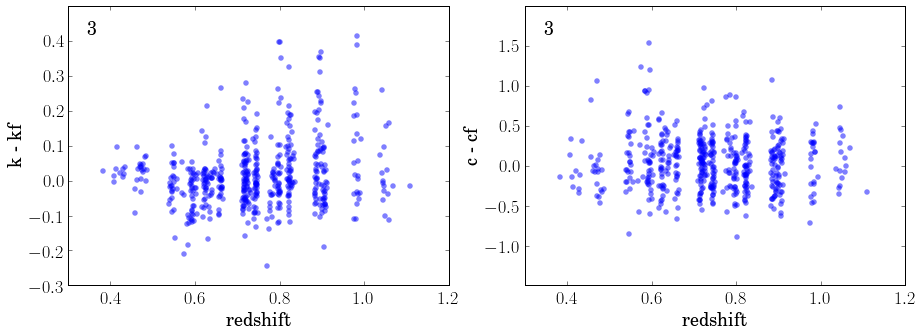

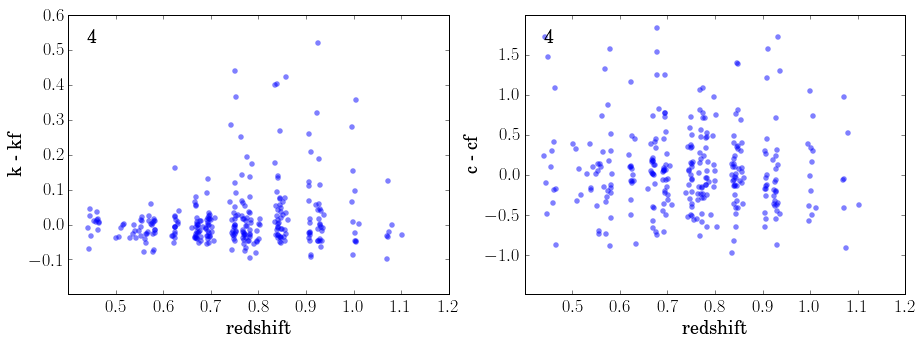

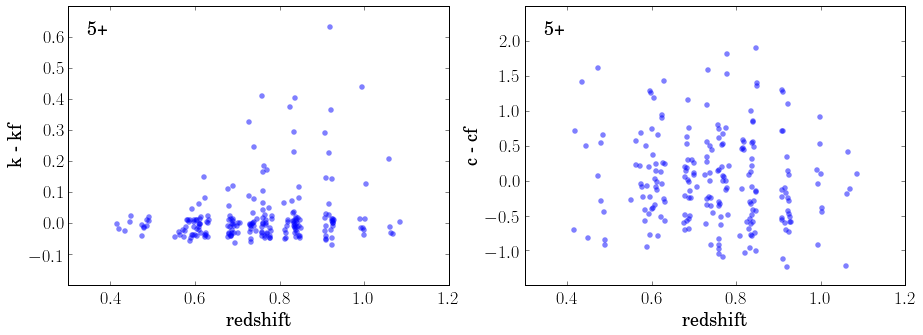

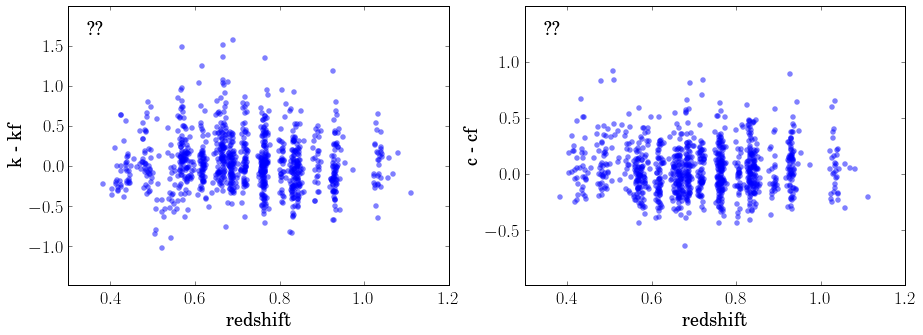

In [60]:
for a in range(len(questions['t11_arms_number']['answers'])):
    plot_kc_fit_difference(a,zc='R50')

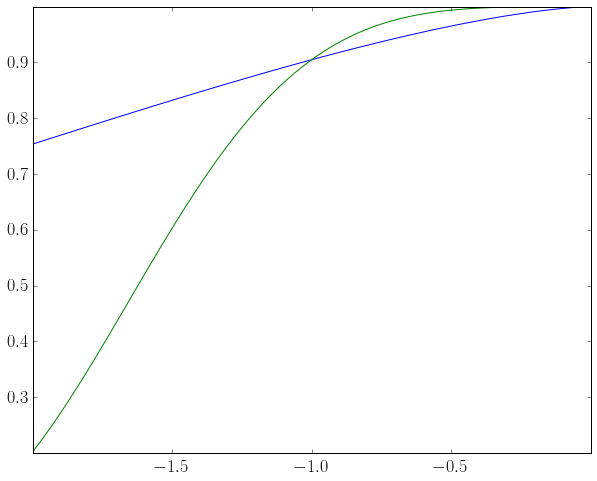

In [52]:
def f(x,k,c):
    return np.exp(-k * (-x) ** c)

xg = np.linspace(-2,0,100)

k = 0.1
for c in [1.5,4]:
    plt.plot(xg,f(xg,k,c))

Finally just show a scatter plot to show how the data is being debiased with z- again, points are blue -> red with redshift.

In [ ]:
raw_debiased_scatter(full_data,'t11_arms_number',method=None,volume_limit=True,Np=10**4)

Finally include a selection of galaxy images to look at galaxies that have been debiased with redshift:

In [ ]:
random.seed(1)
image_page('t11_arms_number',questions,mass_cut=[10.6,11],title=False,print_ID=True,saved=False)
plt.savefig('Plotting_codes/figures/image_page_p0506_m106110.pdf')

In [ ]:
id = 587733609630531886

i = full_data['dr7objid_1'] == id
id_sample = full_data[i]

labels = questions['t11_arms_number']['answers']

for m,label in enumerate(labels):
    print(id_sample['t11_arms_number_' + label + '_weighted_fraction'])
    
for m,label in enumerate(labels):
    print(id_sample['t11_arms_number_' + label + '_debiased_rh'])

In [ ]:
random.seed(1)
image_page('t11_arms_number',questions,mass_cut=[10,11],p_cut=[0.8,1],title=False,print_ID=True,saved=False)
plt.savefig('Plotting_codes/figures/image_page_p0810_m106110.pdf')

How many galaxies are possibly 'saveable'?

In [ ]:
plot_5_arm_fractions(full_sample,questions)

What do these galaxies actually look like with $p_{5+,raw} \sim 0.05$? Some of these around $p \sim 0.05$ do look 'salvageable'?

In [ ]:
random.seed(0)
plot_high_z_5_arm_galaxies(questions)
plot_high_z_5_arm_galaxies(questions)
plot_high_z_5_arm_galaxies(questions)

In [ ]:
from scipy.optimize import curve_fit

def log_fun(x,k,c):
    return k*np.log10(x) + c

def inv_fun(x,k,c):
    return k*(1/x) + c

def plot_k_z_dependence(question='t11_arms_number',answer='a36_more_than_4',string='k'):
    
    xg = np.linspace(0.02,0.11,100)
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    
    f_r_sigma = fit_results[fit_results['in_2sigma'] == True]
        
    kmin,kmax,cmin,cmax = [np.min(f_r_sigma['k']),np.max(f_r_sigma['k'])
                           ,np.min(f_r_sigma['c']),np.max(f_r_sigma['c'])]
    # Set limits here:
    fit_results['kf'][fit_results['kf'] > kmax] = kmax
    fit_results['kf'][fit_results['kf'] < kmin] = kmin
    fit_results['cf'][fit_results['cf'] > cmax] = cmax
    fit_results['cf'][fit_results['cf'] < cmin] = cmin

    z = fit_results['redshift']

    plt.scatter(fit_results['redshift'],fit_results[string],color='k',lw=0,s=30,alpha=1)
    plt.scatter(fit_results['redshift'],fit_results[string+'f'],color='b',lw=0,s=50,alpha=0.5)
    plt.xlabel('z')
    plt.ylabel(string)
    
    for f in [log_fun]:
        
        p,pc = curve_fit(f,fit_results['redshift'],fit_results[string])
        plt.plot(xg,f(xg,*p),'k--',linewidth=2)
    
    return None

$k$ and $c$ histograms

In [ ]:
plt.figure(1)
plot_k_z_dependence(string='k')
plt.figure(2)
plot_k_z_dependence(string='c')

bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset('t11_arms_number','a36_more_than_4')

from sklearn.neighbors.kde import KernelDensity

k = np.sort(fit_results['k'])[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(k)
log_dens = kde.score_samples(k)

plt.plot(k,np.exp(log_dens),'k--',linewidth=3)
_ = plt.hist(k,bins=30,normed=True,alpha=0.3)

c = np.sort(fit_results['c'])[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(c)
log_dens = kde.score_samples(c)

plt.plot(c,np.exp(log_dens),'k--',linewidth=3)
_ = plt.hist(c,bins=30,normed=True,alpha=0.3)

$p>0.5$ line plots w.r.t redshift:

In [ ]:
vl_data = full_data[full_data['in_volume_limit'] == True]

question_order = ['t01_smooth_or_features'
                  ,'t02_edgeon'
                  ,'t03_bar'
                  ,'t04_spiral'
                  ,'t05_bulge_prominence'
                  ,'t06_odd'
                  ,'t07_rounded'
                  ,'t09_bulge_shape'
                  ,'t08_odd_feature'
                  ,'t10_arms_winding'
                  ,'t11_arms_number']

fig,axes = plt.subplots(3,4,figsize=(20,20*(3/4)),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for ax in axes[:,0]:
    ax.set_ylabel('$f(p>0.5)$',size=15)
for ax in axes[-1]:
    ax.set_xlabel('redshift',size=15)

axes = axes.ravel()

line1, = plt.plot([999,999],'k-',label='raw',linewidth=2)
line2, = plt.plot([999,999],'k:',label='W13',linewidth=2)
line3, = plt.plot([999,999],'k--',label='This paper',linewidth=2)
lgd2 = axes[-1].legend(handles=[line1,line2,line3],bbox_to_anchor=(0.9,0.8))
axes[-1].set_frame_on(False)
axes[-1].set_xticks([])
axes[-1].set_yticks([])
axes[-1].set_xlabel('')
axes[-1].set_ylabel('')

plt.ylim(0,1.1)
plt.xlim(0.035,0.085)

alphabet = 'abcdefghijklmnopqrstuvwxyz'

for Q,question in enumerate(question_order):
    
    plt.sca(axes[Q])
    plot_means(vl_data,questions,question)
    plt.text(0.025,0.98,'({})'.format(alphabet[Q]),family='serif'
             ,horizontalalignment='left',verticalalignment='top'
             ,transform = plt.gca().transAxes,size=15)
    
plt.savefig('Plotting_codes/figures/all_thresholds.pdf')